# Проект "Определение возраста покупателей"

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Необходимо **построить модель, которая по фотографии определит приблизительный возраст человека**. В качестве данных выступает набор фотографий людей с указанием возраста.

**Описание данных**:

Данные взяты с сайта `ChaLearn Looking at People`. Они находятся в папке `/datasets/faces/`. В процессе работы будут использованы:
- `/final_files` — папка со всеми изображениями
- `labels.csv` — CSV-файл с двумя колонками: `file_name` и `real_age`.

**План работы над задачей:**

1) **Исследовательский анализ данных** — ознакомимся с устройством датасета и построим график распределения возраста в выборке.

2) **Обучение моделей** — подготовим данные и обучим модель на основе `ResNet50` с оптимизатором `Adam`.

3) Сделаем **итоговый вывод** об основных итогах исследования и предложим заказчику лучшую модель.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb 
import os

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rcParams, rcParamsDefault
rcParams['figure.figsize'] = 10, 6
%config InlineBackend.figure_format = 'svg'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

def plot_describe (t, x_l, y_l): # Заранее пропишем функцию, подписывающую название графика и осей
    plt.title(t)                 # Здесь параметр t будет отвечать за название графика  
    plt.xlabel(x_l)              # Параметр x_l — за подпись горизонтальной оси
    plt.ylabel(y_l)              # Параметр y_l — за подпись вертикальной оси
    plt.show()

## Исследовательский анализ данных

In [2]:
pth1 = 'C:/pr/datasets/faces/labels.csv' # Считаем csv-файл
pth2 = '/datasets/faces/labels.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
else:
    print('Something is wrong')

Изучим общую информацию о датасете. Однако, прежде чем мы приступим к её разбору, напишем **вспомогательную функцию**. Так проводить анализ будет быстрее и удобнее:

In [3]:
def describe_data (data):
    print('Первые пять строк таблицы:')
    display(data.head())
    print('\n', 'Последние пять строк таблицы:')
    display(data.tail())
    print('\n', 'Общая информация о датасете:', '\n')
    data.info()
    print('\n', 'Описательные статистики датасета:')
    display(data.describe().round(2))
    print('\n', 'Количество пропусков в данных:')
    display(data.isna().sum())

In [4]:
describe_data(data) # Изучаем данные о датасете

Первые пять строк таблицы:


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17



 Последние пять строк таблицы:


,file_name,real_age
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20
7590,007612.jpg,47



 Общая информация о датасете: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB

 Описательные статистики датасета:


,real_age
count,7591.00
mean,31.20
std,17.15
min,1.00
25%,20.00
50%,29.00
75%,41.00
max,100.00



 Количество пропусков в данных:


file_name    0
real_age     0
dtype: int64

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe( # Подключаем динамическую загрузку данных
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


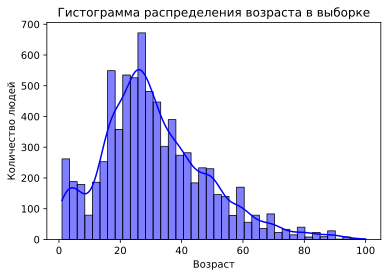

In [6]:
sb.histplot(data['real_age'], bins=40,
            common_norm=False, color='blue', kde=True)
plot_describe('Гистограмма распределения возраста в выборке',
              'Возраст', 'Количество людей')

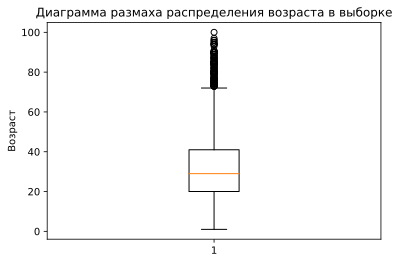

In [7]:
plt.boxplot(data['real_age'])
plot_describe('Диаграмма размаха распределения возраста в выборке', '',
              'Возраст')

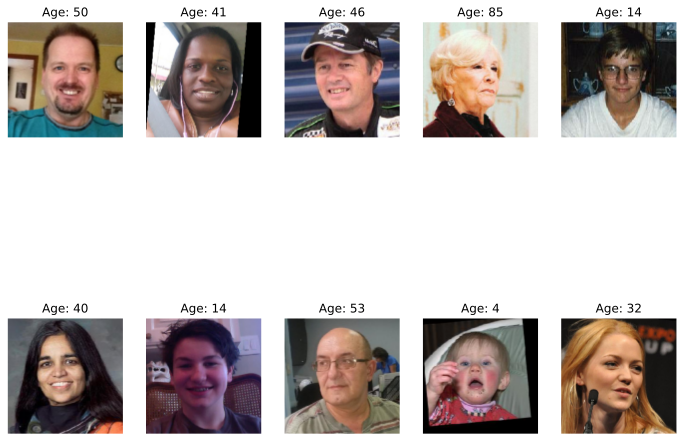

In [8]:
images, labels = next(train_gen_flow) # Выведем на экран 10 фотографий для лучшего ознакомления с датасетом
plt.figure(figsize=(12, 10)) 
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f'Age: {labels[i]}')
    plt.axis('off')

plt.show()

**Промежуточный вывод:**

Анализ датасета выявил следующие возможные проблемы: 
   - Во-первых, качество изображений — некоторые фотографии довольно размыты, содержат помехи и артефакты, сделаны с плохим освещением, повёрнуты или на них вообще плохо различимо лицо человека. Это может привести к меньшей точности работы модели.
   - Во-вторых, в датасете ощущается явный перевес в сторону более молодых людей, что в целом объяснимо средней продолжительностью жизни, однако этот фактор также может повлиять на точность работы модели.
   - В-третьих, возраст на фотографии может не совпадать с реальным возрастом человека. Люди могут выглядеть моложе или старше своего возраста из-за различных факторов, таких как освещение, наличие макияжа или морщин, а также выраженность тех или иных черт лица.

## Обучение модели

Код в этом разделе запускался в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке. Аналогично, текстом оформлен и вывод результатов работы модели.

```python

def load_train(path): # Загружаем тренировочные данные
    datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)
    labels_df = pd.read_csv(f'{path}/labels.csv')

    train_datagen = datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_datagen

def load_test(path): # Загружаем тестовые данные
    datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)
    labels_df = pd.read_csv(f'{path}/labels.csv')

    test_datagen = datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_datagen

def create_model(input_shape): # Создаём модель на основе ResNet50
    optimizer = Adam(learning_rate=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1))

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

# Обучаем модель:
def train_model(model, train_data, test_data, batch_size=None, epochs=8, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

if __name__ == "__main__":
    train_data = load_train()
    test_data = load_test()
    model = create_model(input_shape=(224, 224, 3))
    model = train_model(model, train_data, test_data)
```

```
Train for 190 steps, validate for 48 steps    
Epoch 1/8    
190/190 - 66s - loss: 224.5702 - mae: 10.7105 - val_loss: 998.5953 - val_mae: 26.7571
Epoch 2/8
190/190 - 45s - loss: 59.5962 - mae: 5.8238 - val_loss: 1007.1259 - val_mae: 26.8845
Epoch 3/8
190/190 - 56s - loss: 28.4851 - mae: 4.1273 - val_loss: 307.7929 - val_mae: 12.6173
Epoch 4/8
190/190 - 51s - loss: 20.7646 - mae: 3.4786 - val_loss: 104.2783 - val_mae: 7.6552
Epoch 5/8
190/190 - 45s - loss: 16.6450 - mae: 3.1321 - val_loss: 99.0634 - val_mae: 7.9273
Epoch 6/8
190/190 - 56s - loss: 14.5125 - mae: 2.9545 - val_loss: 84.6882 - val_mae: 6.7794
Epoch 7/8
190/190 - 49s - loss: 11.4233 - mae: 2.5949 - val_loss: 68.1970 - val_mae: 6.4011
Epoch 8/8
190/190 - 47s - loss: 9.6378 - mae: 2.3539 - val_loss: 62.9183 - val_mae: 5.9997
48/48 - 9s - loss: 62.9183 - mae: 5.9997
    
Test MAE: 5.9997   
```

## Анализ обученной модели

В ходе работы над проектом была **обучена модель на основе `ResNet50`**, решающая задачу регрессии, а именно — предсказания возраста человека по фотографии. На тесте данная модель продемонстировала отличные показатели **целевой метрики: MAE = 5.9997**. 

Также в процессе работы был проведён исследовательский анализ данных, позволивший выделить потенциальные проблемы, которые могли возникнуть в работе модели. К ним можно отнести:
1) Качество изображений — некоторые фотографии довольно размыты, содержат помехи и артефакты, сделаны с плохим освещением, повёрнуты или на них вообще плохо различимо лицо человека.

2) Несбалансированность данных в датасете — наблюдался явный перевес в сторону более молодых людей.

3) Возможное различие реального возраста человека с его внешним видом — люди могут выглядеть моложе или старше своего возраста из-за различных факторов, таких как освещение, наличие макияжа или морщин, а также выраженность тех или иных черт лица.